In [1]:
import numpy as np
import copy
from multiprocessing import Pool
import multiprocessing
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import pickle 
%matplotlib inline

In [2]:
def init_pi(N_a,N_s):
    """
    function to generate policy,
    inputs:
        N_a - number of actions;
        N_s - number of states;
    outputs:
        pi(a|s) - np.array of shape N_a x N_s
    """
    np.random.seed(1453)
    Pi_matr = np.random.uniform(0.0,1.0,(N_a,N_s))
    norm_coef = Pi_matr.sum(axis=0)
    Pi_matr = Pi_matr / norm_coef.reshape((1,N_s))
    #check if stochastic
    #print(Pi_matr.sum(axis=0))
    return Pi_matr

In [3]:
def generate_dynamics(N_a,N_s,b):
    """
    function to generate transition probabilities,
    inputs:
        N_a - number of actions;
        N_s - number of states;
        b - branching number
    outputs:
        pi(s'|s,a) - np.array of shape N_s x N_s x N_a
    """
    np.random.seed(1812)
    inds_nonzero = np.zeros((N_s,N_a,b),dtype = int)
    for i in range(N_s):
        for j in range(N_a):
            inds_nonzero[i,j] = np.random.choice(N_s, size=b, replace=False)
    Pi_matr = np.zeros((N_s,N_s,N_a),dtype=float)
    for i in range(N_s):
        for j in range(N_a):
            Pi_matr[inds_nonzero[i,j],i,j] = np.random.uniform(0.0,1.0,b)
    norm_coef = Pi_matr.sum(axis=0)
    Pi_matr = Pi_matr / norm_coef.reshape((1,N_s,N_a))
    return Pi_matr,inds_nonzero

In [4]:
def state_transitions(P,pi):
    """
    function to generate transition probabilities,
    inputs:
        P(s'|s,a) - np.array of shape N_s x N_s x N_a, transition probabilities;
        pi(a|s) - np.array of shape N_a x N_s, policy;
    outputs:
        p(s'|s) - transition probability matrix of shape (N_s,N_s)
    """
    np.random.seed(1812)
    P_s = np.zeros((N_s,N_s),dtype = float)
    for i in range(N_s):
        for j in range(N_s):
            P_s[i,j] = np.dot(P[i,j,:],pi[:,j])
    return P_s 

In [5]:
def init_rewards(N_a,N_s):
    """
    function to generate rewards,
    inputs:
        N_a - number of actions;
        N_s - number of states;
    outputs:
        R(a,s) - np.array of rewards (shape N_a x N_s)  
    """
    np.random.seed(1821)
    R = Pi_matr = np.random.uniform(0.0,1.0,(N_a,N_s))
    return R

In [6]:
#global constants
#number of actions
N_a = 2
#number of states
N_s = 10
#gamma = 0.99
gamma = 0.9
#branching factor (external parameter for Garnet)
branch = 3

In [7]:
#init policy matrix
Policy = init_pi(N_a,N_s)
#init transition matrix
P,Inds_nz = generate_dynamics(N_a,N_s,branch)
#init rewards
R = init_rewards(N_a,N_s)
#init state transition matrix
S_trans = state_transitions(P,Policy)

### Solve system to find $\theta^*$ (i.e. true $V_{\pi}(s)$)

In [8]:
#system matrix
A = np.eye(N_s) - gamma*(S_trans.T)
#right hand side
b = np.sum(Policy*R,axis=0)
theta_star = np.linalg.inv(A) @ b
print(b)
print(theta_star)

[0.71889809 0.56176203 0.7028568  0.58086509 0.11065385 0.48332232
 0.34350863 0.70097716 0.55115417 0.51374463]
[5.27220987 5.22225305 5.43806472 5.27366874 4.83310775 5.03090872
 5.08173115 5.26029066 5.11108826 5.19779703]


### Find stationary distribution over state space

In [9]:
#note that in my notations they are usual (right) eigenvalues
eigvals, eigfuncs = np.linalg.eig(S_trans)
print(eigvals)
pi_states = -np.real(eigfuncs[:,0])
pi_states = pi_states/np.sum(pi_states)
#pi_states - statinary distribution over states
print(pi_states)
print(np.sum(pi_states))

[ 1.        +0.j          0.04375658+0.41636321j  0.04375658-0.41636321j
 -0.26498642+0.j         -0.16641571+0.19627497j -0.16641571-0.19627497j
  0.18278929+0.j          0.14418946+0.08057296j  0.14418946-0.08057296j
  0.0729122 +0.j        ]
[0.061358   0.12973764 0.12527139 0.14823597 0.09849189 0.04864512
 0.14811634 0.07481129 0.11326694 0.05206541]
1.0


In [10]:
#calculate covariance matrix Sigma_epsilon
Sigma_eps = np.zeros((N_s,N_s),dtype=float)
for s0 in range(N_s):
    for s in range(N_s):
        for a in range(N_a):
            eps = np.zeros(N_s,dtype=float)
            eps[s0] = R[a,s0] + gamma*theta_star[s]-theta_star[s0]
            eps_upd = eps.reshape((-1,1)) @ eps.reshape((1,-1))
            #averaging
            Sigma_eps += pi_states[s0]*Policy[a,s0]*P[s,s0,a]*eps_upd
#print estimated covariance matrix
print(Sigma_eps)

[[0.00161236 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.00371063 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.02791094 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.00269599 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.00171354 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.00254726
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00806724 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.00331585 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.00275466 0.        ]
 [0.         0.         0.   

### Find $\theta^*$ by another approach

In [11]:
A_star = np.zeros((N_s,N_s),dtype=float)
for i in range(N_s):
    for j in range(N_s):
        A_star[i,j] = pi_states[i]*S_trans[j,i]
A_star = np.diag(pi_states) - gamma*A_star
b_star = b*pi_states
theta_star_new = np.linalg.inv(A_star) @ b_star
print("error between different ways of calculating thetas star",np.linalg.norm(theta_star-theta_star_new))

error between different ways of calculating thetas star 1.130466570252318e-14


In [12]:
#Run TD(0) algorithm
N_iters = 2*10**6
v0 = 5*np.ones(N_s,dtype=float)
s0 = np.random.choice(N_s)
#step size
c0 = 4.0
alpha = np.zeros(N_iters,dtype=float)
for i in range(N_iters):
    alpha[i] = c0/np.sqrt(i+1)

### Check quality of normal approximation

In [35]:
print(res_pr.shape)
res_pr.dtype

(10, 163840, 10)


dtype('float64')

In [21]:
np.random.seed(2024)
#choose number of iterations
N_iters = [200,400,800,1600,3200,6400,12800,25600,51200,102400]

#generate random direction
U = np.random.randn(N_s)
u = U/np.linalg.norm(U)
#compute the emirical CDF 
res_pr = np.load("result/PR_V_iter=307200,seed=2024,alpha=0.5,N_traj=163840,N_iters=102400.npy")
pr_samples = []

for i in range(len(N_iters)):
    print(res_pr[i].shape)
    norm_samples = np.sqrt(N_iters[i])*A_star @ (res_pr[i] - theta_star.reshape((1,-1))).transpose()
    pr_samples.append(norm_samples)

(163840, 10)
(163840, 10)
(163840, 10)
(163840, 10)
(163840, 10)
(163840, 10)
(163840, 10)
(163840, 10)
(163840, 10)
(163840, 10)


In [28]:
pr_samples[5]

array([[-0.00225602,  0.00174693, -0.02679395, ..., -0.02738779,
        -0.0468154 , -0.04518233],
       [-0.02290576,  0.10492261,  0.06820008, ..., -0.04127685,
         0.04341928, -0.03295442],
       [ 0.13954348, -0.08212541,  0.10659229, ...,  0.2429698 ,
        -0.06782192,  0.05847833],
       ...,
       [-0.02640961, -0.03497997, -0.07756362, ..., -0.08923083,
        -0.10084474, -0.02906413],
       [-0.04471603, -0.04350765, -0.04172802, ..., -0.02821947,
        -0.0066639 ,  0.09830373],
       [-0.01225248, -0.04303418, -0.00083474, ...,  0.00304918,
        -0.03099559,  0.00461233]])

In [16]:
sample = []
for i in range(len(N_iters)):
    err_proj = pr_samples[i].transpose() @ u
    sample.append(err_proj)
sample = np.asarray(sample)
print(sample.shape)

(10, 163840)


In [17]:
N_traj = 163840

all_ks = []
loc = 0.0
scale = (Sigma_eps @ u).dot(u)
for i in range(len(N_iters)):
    sample_sort = np.sort(sample[i])
    ecdf = np.linspace(0,1,N_traj+1)
    cdfs = norm.cdf(sample_sort, loc = 0, scale = np.sqrt(scale))
    ks_dist = max([(ecdf[1:] - cdfs).max(), (cdfs - ecdf[:-1]).max()])
    all_ks.append(ks_dist)

In [20]:
print(all_ks)

[0.23250917649331776, 0.172291799670936, 0.11365274128737313, 0.06471137290618645, 0.031300861630547516, 0.014299627299976692, 0.005199041858458764, 0.00311437617561805, 0.0038341079419312862, 1.0]


In [30]:
N_iters_new = N_iters[:-1]
print(N_iters_new)

[200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200]


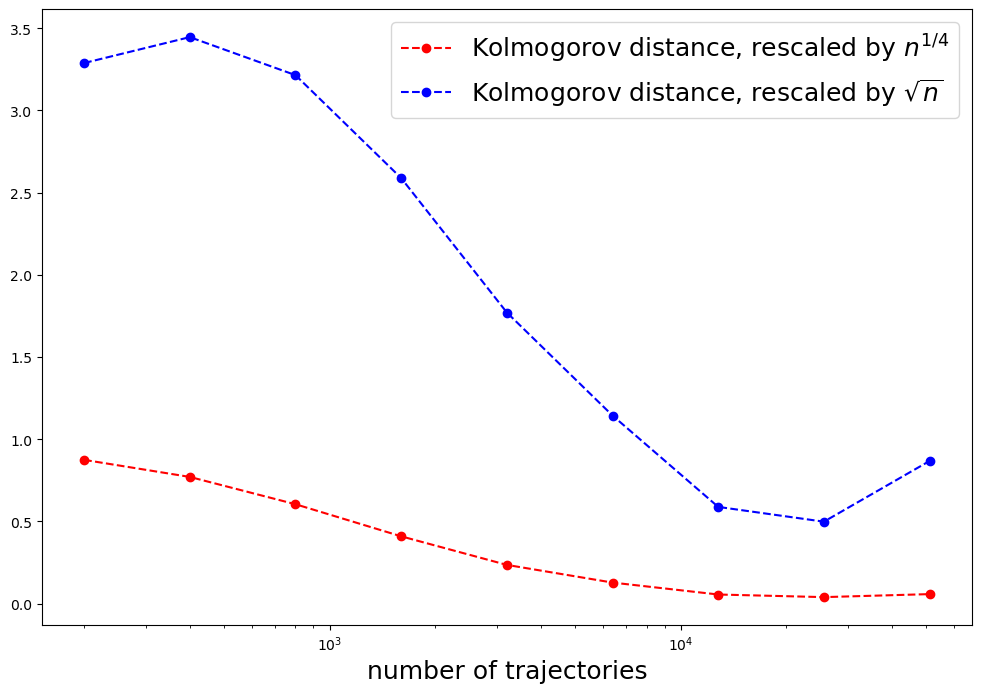

In [32]:
#plot last iterate
N_iters_new = np.asarray(N_iters_new,dtype=float)
plt.figure(figsize=(12,8)) 
plt.plot(N_iters_new, (N_iters_new**0.25)*all_ks[:-1], linestyle='--', marker='o', color='r', label='Kolmogorov distance, rescaled by $n^{1/4}$') 
plt.plot(N_iters_new, (N_iters_new**0.5)*all_ks[:-1], linestyle='--', marker='o', color='b', label='Kolmogorov distance, rescaled by $\sqrt{n}$') 
plt.xlabel('number of trajectories',fontsize = 18)
plt.xscale('log')
#plt.yscale('log')
plt.legend(fontsize=18)
plt.savefig("test_kolmogorov_dist_18_05_small.pdf")
plt.show()